## Camera pixel calibration 

In [1]:
from datetime import datetime
import os
import sys

import h5py
from matplotlib import colors
from matplotlib import pyplot as plt
import imageio
from ipywidgets import interactive
from matplotlib import cm
import numpy as np
import pandas as pd
from pprint import pprint
import proplot as pplt
from scipy.signal import wiener

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False

In [3]:
datadir = '/Users/46h/Dropbox (ORNL)/work/btf-data/2022-11-03/'
os.listdir(datadir)

['221103151618-camera_pixel_calibration.h5',
 '221103153958-camera_pixel_calibration.h5']

In [5]:
filename = '221103153958-camera_pixel_calibration.h5'
cam = 'Cam06'
zoom = 0.25

In [6]:
file = h5py.File(os.path.join(datadir, filename), 'r')
data = file['scandata']
pprint(data.dtype.fields)

mappingproxy({'Cam06_ProfileX': (dtype(('<f4', (612,))), 16),
              'iteration': (dtype('int64'), 8),
              'screen_PositionSync': (dtype('<f8'), 2464),
              'timestamp': (dtype('<f8'), 0)})


In [7]:
if 'config' in file:
    config = file['config']
    print(f"'config', {type(config)}")
    for key in config:
        print(f"  '{key}', {type(config[key])}")
        for name in config[key].dtype.names:
            print(f'    {name}: {config[key][name]}')
    # Make dictionary of metadata
    metadata = dict()
    for name in config['metadata'].dtype.names:
        metadata[name] = config['metadata'][name]
else:
    # Older measurement; metadata is in json file.
    metadata = json.load(open(join(datadir, filename + '-metadata.json'), 'r'))
    _metadata = dict()
    for _dict in metadata.values():
        for key, value in _dict.items():
            _metadata[key] = value
    metadata = _metadata
    pprint(metadata)

'config', <class 'h5py._hl.group.Group'>
  'environment', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.6675044e+09]
    user: [b'physics']
    host: [b'btf-diag-app1.ics.sns.gov']
    cmd_line: [b'misc/camera_pixel_calibration.py']
    work_dir: [b'/home/physics/btf-scripts']
  'metadata', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.66750441e+09]
    Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.]
    RFTF_TM:Gate_BeamOn:RR: [5.]
    BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
    BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
    BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
    BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
    BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
    BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
    BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
    BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
    BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
    BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
    BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
    BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55]
    BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
    BTF_MEBT_Mag:PS_QH33:I_Set: [5.1]
   

In [8]:
if 'log' in file:
    log = file['log']
    print(f"'log', {type(log)}")
    for item in log.dtype.fields.items():
        print('  ', item)

    print('\nErrors and warnings:')
    for i in range(log.size):
        if not(log[i, 'level'] == 'INFO'.encode('utf')):
            timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
            print(f"{timestr} {log[i, 'message']}")

'log', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('level', (dtype('S15'), 8))
   ('source', (dtype('S20'), 23))
   ('message', (dtype('S512'), 43))

Errors and warnings:


In [9]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('Cam06_ProfileX', (dtype(('<f4', (612,))), 16))
   ('screen_PositionSync', (dtype('<f8'), 2464))


## Screen edge

In [10]:
def update(i):
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.plot(data[i, f'{cam}_ProfileX'], color='black')
    
interactive(update, i=(0, len(data) - 1))

interactive(children=(IntSlider(value=39, description='i', max=79), Output()), _dom_classes=('widget-interact'…

In [11]:
lo = 0
hi = len(data)

profiles = data[lo:hi, f'{cam}_ProfileX']
slitpos = data[lo:hi, 'screen_PositionSync']

pix0 = 0
pixf = 375
profiles = profiles[:, pix0:pixf]

/Users/46h/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/Users/46h/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


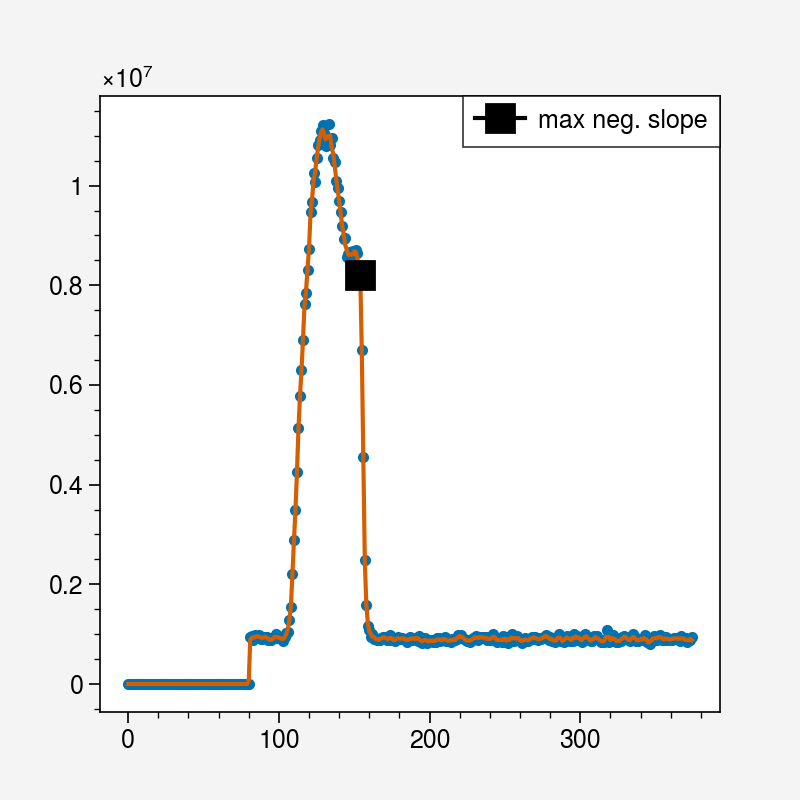

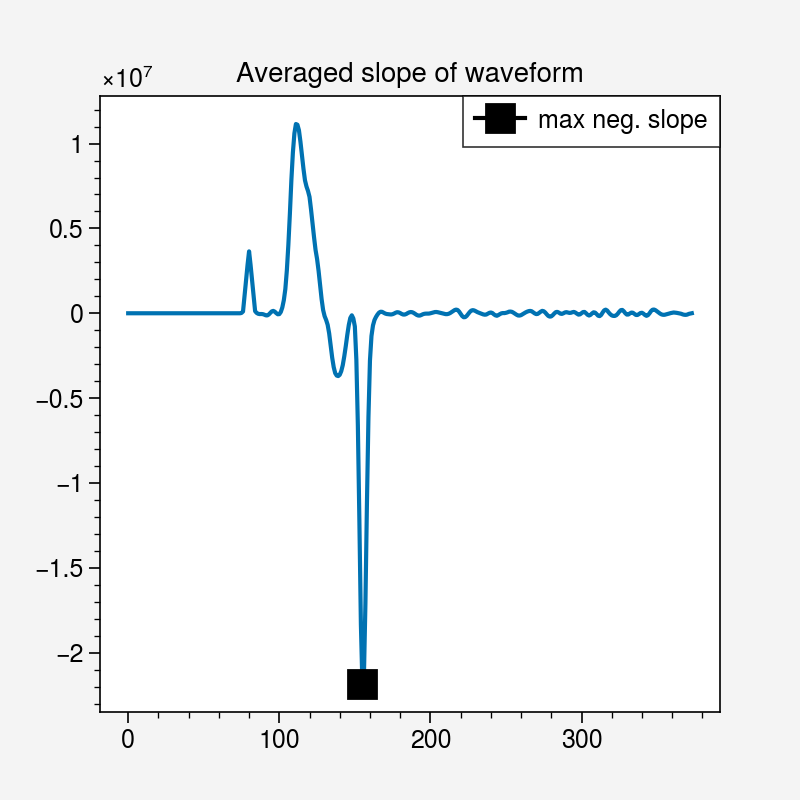

In [12]:
# -- test single wf
idy = 0
fsize = 3

# -- smooth
wf = wiener(profiles[idy,:],mysize=fsize)
# -- differentiate
dwf = wf[1:] - wf[0:-1]
# -- smooth differentiation
dwf = wiener(dwf, mysize=fsize)
# -- avg over nearest four slope points
dwf[1:] += dwf[0:-1]
dwf[0:-1] += dwf[1:]
dwf[2:] += dwf[0:-2]
dwf[0:-2] += dwf[2:]

# -- edge is point with highest slope
idx = np.argmin(dwf) - 1

plt.figure()
plt.plot(np.arange(pix0, pixf), profiles[idy, :], '.')
plt.plot(np.arange(pix0, pixf), wf, '-')
plt.plot(pix0 + idx, wf[idx], marker='s', color='black', markersize=10, label='max neg. slope')
plt.legend()

plt.figure()
plt.title('Averaged slope of waveform')
plt.plot(dwf)
plt.plot(idx + 1, dwf[idx + 1], marker='s', color='black', markersize=10, label='max neg. slope')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=[10,5])
plt.xlabel('VS pixels');
plt.ylabel('signal, Cam09:ProfileY')

iedge = np.zeros(endi-starti)
for ii in range(np.shape(dattr)[0]):
    # -- smooth
    wf = wiener(dattr[ii,:],mysize=fsize)
    # -- differentiate
    dwf = wf[1:] - wf[0:-1]
    # -- smooth differentiation
    dwf = wiener(dwf,mysize=fsize)
    # -- avg over nearest four slope points
    dwf[1:] += dwf[0:-1]
    dwf[0:-1] += dwf[1:]
    dwf[2:] += dwf[0:-2]
    dwf[0:-2] += dwf[2:]
    # -- edge is point with highest slope
    idx = np.argmin(dwf) -1
    
    # -- plot
    plt.plot(wf)
    plt.plot(idx,wf[idx],'ko')
    
    # -- save
    iedge[ii] = idx

plt.figure()
plt.plot(slitpos, iedge, '.')
plt.title('pix2mm = %.4f mm/pixel +- %.4f '%(slope, var_slope))
plt.xlabel('VS position [mm]')
plt.ylabel('Location max. neg. slope[pixels]')

pfit, COV = np.polyfit(iedge, slitpos, 1, cov=True) 
slope = pfit[0] * zoom_mult
var_slope = np.sqrt(COV[0, 0]) * zoom_mult
print('pix2mm = %.4f mm/pixel +- %.4f '%(slope, var_slope))
p = np.poly1d(pfit)
plt.plot(p(iedge), iedge);